# Using ADAM-API to access MODIS Aqua CHL

- you need to get an account to https://reliance.adamplatform.eu/ (use ORCID to authenticate) and key your ADAM API key
- make sure you save your ADAM API key in a file `$HOME/adam-key`

In [1]:
!pip install adamapi

In [37]:
!pip install cmocean

     |████████████████████████████████| 223 kB 5.5 MB/s eta 0:00:01


In [38]:
import os
import glob
import pathlib
import zipfile
import adamapi as adam
import xarray as xr
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

## Authenticate to ADAM platform with ADAM API key

In [5]:
adam_key = open(os.path.join(os.environ['HOME'],"adam-key")).read().rstrip()

In [6]:
a = adam.Auth()

a.setKey(adam_key)
a.setAdamCore('https://reliance.adamplatform.eu')
a.authorize()

{'expires_at': '2021-12-08T20:07:46.752Z',
 'access_token': 'a34db20c230447059c2cf7586c3e5d63',
 'refresh_token': '17aba7b3192c4f27b47837e93449e4c7',
 'expires_in': 3600}

## Discover MOD_Aqua datasets 
- This step is useful to get the dataset identifier (unique for a given datacube)

In [7]:
def discoverDasasets(a, search_name):
    datasets = adam.Datasets(a)
    catalogue = datasets.getDatasets()
    #Extracting the size of the catalogue
    total = catalogue['properties']['totalResults']
    items = catalogue['properties']['itemsPerPage']
    pages = total//items
    
    print('----------------------------------------------------------------------')
    print('\033[1m' + 'List of available datasets:')
    print ('\033[0m')

    #Extracting the list of datasets across the whole catalogue
    for i in range(0,pages):
        page = datasets.getDatasets(page = i)
        for element in page['content']: 
            if search_name in element['title'] :
                print(element['title'] + "\033[1m" + " --> datasetId "+ "\033[0m" + "= " + element['datasetId'])
    return datasets

In [8]:
datasets = discoverDasasets(a, 'MOD_Aqua')

----------------------------------------------------------------------
List of available datasets:



## Get metadata from Modis Aqua Chlorophylle Concentration

In [9]:
datasetID = '69618:MODh20chlMO_4km'

print('\033[1;34m' + 'Metadata of ' + datasetID + ':')
print ('\033[0;0m')

paged = datasets.getDatasets(datasetID)
for i in paged.items():
    print("\033[1m" +  str(i[0]) + "\033[0m" + ': ' + str(i[1]))

Metadata of 69618:MODh20chlMO_4km:

datasetId: 69618:MODh20chlMO_4km
creationDate: 2018-12-01T00:10:01Z
dataType: Float32
epsg: 4326
keywords: ['/processing_control/input_parameters/NC_GLOBAL#alt_thresh_lat=999', '/processing_control/input_parameters/NC_GLOBAL#apply_pal=1', '/processing_control/input_parameters/NC_GLOBAL#central_meridian=-999', '/processing_control/input_parameters/NC_GLOBAL#deflate=4', '/processing_control/input_parameters/NC_GLOBAL#east=180.000', '/processing_control/input_parameters/NC_GLOBAL#fudge=1.0', '/processing_control/input_parameters/NC_GLOBAL#full_latlon=yes', '/processing_control/input_parameters/NC_GLOBAL#interp=area', '/processing_control/input_parameters/NC_GLOBAL#land=$OCDATAROOT/common/landmask_GMT15ARC.nc', '/processing_control/input_parameters/NC_GLOBAL#mask_land=no', '/processing_control/input_parameters/NC_GLOBAL#north=90.000', '/processing_control/input_parameters/NC_GLOBAL#num_cache=500', '/processing_control/input_parameters/NC_GLOBAL#oformat=2

## Discover and select products from a dataset
- for a given time range and spatial coverage

### Get data over Artic region
- The geometry field is extracted from a GeoJSON object , retrieving the value of the "feature" element.

#### Search data
- only print the first 10 products

In [10]:
from adamapi import Search

The GeoJson object needs to be rearranged according to the counterclockwise winding order.This operation is executed in the next few lines to obtain a geometry that meets the requirements of the method. Geom_1 is the final result to be used in the discovery operation.

In [11]:
geom_1 = "{'type': 'Polygon', 'coordinates': [[[-180, 90], [180, 90], [180, 60], [-180, 60], [-180, 90]]]}"

In [12]:
start_date = '2003-01-01'
end_date = '2003-12-31'

In [13]:
search = Search( a )
results = search.getProducts(
    datasetID, 
    geometry= geom_1,
    startDate = start_date,
    endDate = end_date
 )

# Printing the results

print('\033[1m' + 'List of available products:')
print ('\033[0m')
count = 1
for i in results['content']:

        print("\033[1;31;1m" + "#" + str(count))
        print ('\033[0m')
        for k in i.items():
            print(str(k[0]) + ': ' + str(k[1]))
        count = count+1
        print('------------------------------------')

List of available products:

#1

_id: {'$oid': '60e85ffc6dfebc0806d0ec1e'}
datasetId: MODh20chlMO_4km
productDate: 2003-12-01T00:05:00Z
productId: NETCDF:"/mnt/VOL100T/reliance/MODISA_L3m_CHL/2003/12/01/A20033352003365.L3m_MO_CHL_chlor_a_4km.nc":chlor_a
band: 1
bandDescription: mass_concentration_chlorophyll_concentration_in_sea_water
geometry: {'geometries': [{'type': 'Polygon', 'coordinates': [[[-180, -90], [0.0, -90], [0.0, 89.9999975], [-180, 89.9999975], [-180, -90]]]}, {'type': 'Polygon', 'coordinates': [[[0.0, -90], [180, -90], [180, 89.9999975], [0.0, 89.9999975], [0.0, -90]]]}], 'type': 'GeometryCollection'}
insertDate: 2021-07-09T14:41:00Z
platform: A20
status: Online
------------------------------------
#2

_id: {'$oid': '60e860146dfebc0806d0f073'}
datasetId: MODh20chlMO_4km
productDate: 2003-11-01T00:00:00Z
productId: NETCDF:"/mnt/VOL100T/reliance/MODISA_L3m_CHL/2003/11/01/A20033052003334.L3m_MO_CHL_chlor_a_4km.nc":chlor_a
band: 1
bandDescription: mass_concentration_chlorop

## Get data
- be aware that you alwasy get daily average from ADAM-API 

In [14]:
def getZipData(auth, dataset_info):
    if not (pathlib.Path(pathlib.Path(dataset_info['outputFname']).stem).exists() or pathlib.Path(dataset_info['outputFname']).exists()):
        data = adam.GetData(auth)
        image = data.getData(
        datasetId = dataset_info['datasetID'],
        startDate = dataset_info['startDate'],
        endDate = dataset_info['endDate'],
        geometry = dataset_info['geometry'],
        outputFname = dataset_info['outputFname'])
        print(image)

In [15]:
%%time

output_file = './MOD_Aqua_mass_concentration_chlorophyll_concentration_in_sea_water_' + start_date + '-' + end_date + '.zip'

datasetInfo = {
    'datasetID'   : datasetID,
    'startDate'   : start_date,
    'endDate'     : end_date,
    'geometry'    : geom_1,
    'outputFname' : output_file
    }
getZipData(a, datasetInfo)

./MOD_Aqua_mass_concentration_chlorophyll_concentration_in_sea_water_2003-01-01-2003-12-31.zip
CPU times: user 4.15 s, sys: 148 ms, total: 4.29 s
Wall time: 1min 7s


## Data analysis and Visualization

### Unzip data 

In [16]:
def unzipData(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(path = pathlib.Path(filename).stem)

In [17]:
if not pathlib.Path(pathlib.Path(output_file).stem).exists():
    unzipData(output_file)

## Read data in xarray

In [18]:
def paths_to_datetimeindex(paths):
    return  [datetime.strptime(date.split('_')[-1].split('.')[0], '%Y-%m-%dt%f') for date in paths]

In [19]:
def getData(dirtif, varname):
    geotiff_list = glob.glob(dirtif)
    # Create variable used for time axis
    time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list))
    # Load in and concatenate all individual GeoTIFFs
    geotiffs_da = xr.concat([xr.open_rasterio(i, parse_coordinates=True) for i in geotiff_list],
                        dim=time_var)
    # Covert our xarray.DataArray into a xarray.Dataset
    geotiffs_da = geotiffs_da.to_dataset('band')
    # Rename the dimensions to make it CF-convention compliant
    geotiffs_da = geotiffs_da.rename_dims({'y': 'latitude', 'x':'longitude'})
    # Rename the variable to a more useful name
    geotiffs_da = geotiffs_da.rename_vars({1: varname, 'y':'latitude', 'x':'longitude'})
    # set attribute to variable
    geotiffs_da[varname].attrs = {'units' : geotiffs_da.attrs[varname + '#units'], 'long_name' : geotiffs_da.attrs[varname + '#long_name']}
    return geotiffs_da

In [20]:
path_files = os.path.join(pathlib.Path(output_file).stem, '*.tif')
geotiff_ds = getData(path_files, 'chlor_a')

/data/jwd/main/035/876/35876205/tmp/ipykernel_5020/2431546948.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiffs_da = xr.concat([xr.open_rasterio(i, parse_coordinates=True) for i in geotiff_list],
/data/jwd/main/035/876/35876205/tmp/ipykernel_5020/2431546948.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiffs_da = xr.concat([xr.open_rasterio(i, parse_coordinates=True) for i in geotiff_list],


In [26]:
%%time
geotiff_ds.load()

<xarray.Dataset>
Dimensions:    (time: 11, latitude: 720, longitude: 8640)
Coordinates:
  * latitude   (latitude) float64 89.98 89.94 89.9 89.85 ... 60.1 60.06 60.02
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2003-02-01 2003-03-01 ... 2003-12-01
Data variables:
    chlor_a    (time, latitude, longitude) float32 -3.277e+04 ... -3.277e+04
Attributes: (12/128)
    transform:                                                        (0.0416...
    crs:                                                              +init=e...
    res:                                                              (0.0416...
    is_tiled:                                                         0
    nodatavals:                                                       (-32767...
    scales:                                                           (1.0,)
    ...                                                               ...
    NC_GLOBAL#temporal_range:                                         month
    NC_GLOBAL#time_coverage_end:                                      2003-03...
    NC_GLOBAL#time_coverage_start:                                    2003-02...
    NC_GLOBAL#title:                                                  HMODISA...
    NC_GLOBAL#westernmost_longitude:                                  -180
    NC_GLOBAL#_lastModified:                                          2018-01...

## Visualization

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py

CPU times: user 35.2 s, sys: 515 ms, total: 35.7 s
Wall time: 36 s


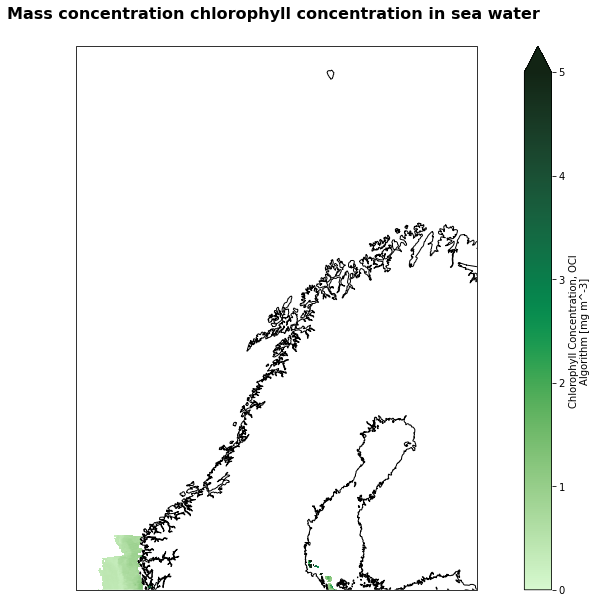

In [40]:
%%time
extent = [0,30,60,75]
fig=plt.figure(figsize=(17,10))
# Define the projection
crs=ccrs.PlateCarree()

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=12.0))
ax.coastlines(resolution='10m')
ax.set_extent(extent, crs=ccrs.PlateCarree())

# We need to project our data to the new Mercator projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
# we only plot values greather than 0
img = geotiff_ds['chlor_a'].isel(time=0).where(geotiff_ds['chlor_a'].isel(time=0)>0).plot(ax=ax, transform=ccrs.PlateCarree(),  vmin=0, vmax=5, cmap=cmocean.cm.algae)  

# Title for plot
plt.title('Mass concentration chlorophyll concentration in sea water \n',fontsize = 16, fontweight = 'bold', pad=10)
plt.savefig('Mod_Aqua-chlor_ARCTIC.png')

In [23]:
geotiff_ds['chlor_a'].to_netcdf('MOD_Aqua_Chl_arctic_2003.nc')